# HW 4 : Clustering 

In this HW we will use K-means variants on Fisher's Iris dataset

In [1]:
# relevant packges
%matplotlib inline
from sklearn import datasets, cluster
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# load data
iris = datasets.load_iris()

X_iris = iris.data
y_iris = iris.target

In [3]:
# Check data type and dim
print (str(type(X_iris)) + 'dimensions: '+str(X_iris.shape))
print (str(type(y_iris)) + 'dimensions: '+str(y_iris.shape))
print (X_iris[1,:])

<type 'numpy.ndarray'>dimensions: (150L, 4L)
<type 'numpy.ndarray'>dimensions: (150L,)
[ 4.9  3.   1.4  0.2]


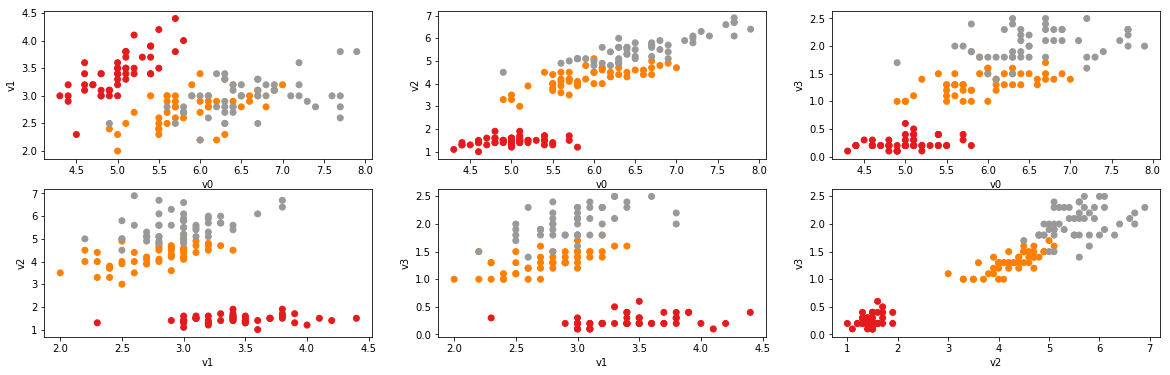

In [4]:
# Visualize 2d projections
fig = plt.figure(1, figsize=(20, 6))
itr = 1
for i in xrange(0,4):
    for j in xrange(i+1,4):
        plt.subplot(2,3,itr)
        plt.scatter(X_iris[:,i], X_iris[:,j], c=y_iris, cmap=plt.cm.Set1)
        plt.xlabel('v'+str(i))
        plt.ylabel('v'+str(j))
        itr+=1

[]

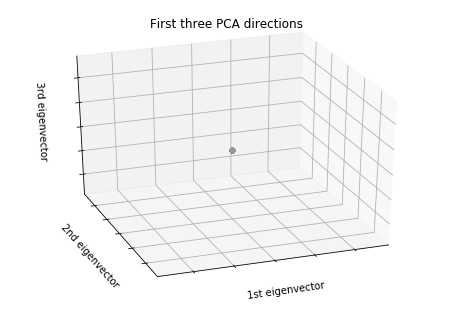

In [5]:
# Question 1 - fill in the code as required
fig = plt.figure(2)
X_reduced = np.zeros((y_iris.size,3))
#  Obtain first 3 PCA directions by using PCA method fit_transform 
######## Your Code Here ##########

#X_reduced = PCA(?).?

##################################
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y_iris,
           cmap=plt.cm.Set1)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

In [97]:
# Question 2 - fill in the code as required

######## Your Code Here ##########
# Cluster via KMeans from cluster
# tweak parameters/ use a grid search for best results

k_means = cluster.KMeans(n_clusters=3)

# We're tweaking parameters based on the documentaion found here:
# http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

##################################
# cluster
k_means.fit(X_iris) 
# obtain labels
sk_k_means_labels = k_means.labels_

In [153]:
# Question 3 - write a function that computes the number of correct labels
def correctLabelNum(y_iris,labels):
    
    SAMPLE = 10
    #Our strategy is to pick #SAMPLE random elements with the same label,
    #and map their label to the predicted label which holds the most of them.
    allIndices = []
    
    for label in [0,1,2]:
        
        indices = np.nonzero(y_iris == label)
        allIndices.append(indices)
    
    selectedIndices = [np.random.choice(labelsList[0],SAMPLE) for labelsList in allIndices]
    
    #Now after we chose the random elements, find the cluster in which most of them are located.
    actualLabels = [] #These is the mapping to the clustering labels.
    
    for indices in selectedIndices:
        curLabels = np.take(labels,indices)
        actualLabels.append(np.argmax(np.bincount(curLabels)))  
    
    labels = [actualLabels[x] for x in labels]
    
    return sum(y_iris == labels)
    




In [185]:
# check precentage of correct classification

print "sklearn K-means classified " + str(correctLabelNum(y_iris,sk_k_means_labels))+ ":"+ str(y_iris.size)+ " correctly"

sklearn K-means classified 134:150 correctly


In [ ]:
# Visualize clustering by sklearn K-means
fig = plt.figure(3)
ax = Axes3D(fig, elev=20, azim=200)
ax.scatter(X_iris[:,3], X_iris[:,0], X_iris[:,2], c=sk_k_means_labels,
           cmap=plt.cm.Set1)

In [ ]:
# Question 4 - Implement K-means by yourself (don't use any k-mean libarary code )
#              your implementation outputs should be consisted with sklearn K-means
class K_means_vanilla:
   def __init__(self,n_clusters=1):
      self.n_clusters = n_clusters
        ######## Your Code Here ##########



        ##################################
   def fit(self,X):
        ######## Your Code Here ##########



        ##################################
   def labels(self):
        ######## Your Code Here ##########



        ##################################

In [ ]:
# Run vanilla K-means on data 
my_K_means_vanilla = K_means_vanilla(n_clusters = 3)
my_K_means_vanilla.fit(X_iris)
vanill_my_k_means_labels = my_K_means_vanilla.labels()

# Visualize vanilla K means clustering
fig = plt.figure(4)
ax = Axes3D(fig, elev=20, azim=200)
ax.scatter(X_iris[:,3], X_iris[:,0], X_iris[:,2], c=vanill_my_k_means_labels,
           cmap=plt.cm.Set1)

# check precentage of correct classification
print "Vanilla K-means classified " + str(correctLabelNum(y_iris,vanill_my_k_means_labels))+ ":"+ str(y_iris.size)+ " correctly"

In [ ]:
# Question 5 - Implement K-Medoids (don't use any k-mean libarary code)
class K_Medoids:
   def __init__(self,n_clusters=1):
      self.n_clusters = n_clusters
        ######## Your Code Here ##########


        ##################################
   def fit(self,X):
        ######## Your Code Here ##########


        ##################################
   def labels(self):
        ######## Your Code Here ##########


        ##################################


In [ ]:
# Run K-Medoids on data 
my_K_Medoids = K_Medoids(n_clusters = 3)
my_K_Medoids.fit(X_iris)
my_K_Medoids_labels = my_K_Medoids.labels()

# Visualize vanilla K means clustering
fig = plt.figure(4)
ax = Axes3D(fig, elev=20, azim=200)
ax.scatter(X_iris[:,3], X_iris[:,0], X_iris[:,2], c=my_K_Medoids_labels,
           cmap=plt.cm.Set1)

# check precentage of correct classification
print "K-Medoids classified " + str(correctLabelNum(y_iris,my_K_Medoids_labels))+ ":"+ str(y_iris.size)+ " correctly"

In [ ]:
# Question 6 - Implement soft K-Means (don't use any k-mean libarary code)
class soft_K_Means:
   def __init__(self,n_clusters=1):
      self.n_clusters = n_clusters
        ######## Your Code Here ##########


        ##################################
   def fit(self,X):
        ######## Your Code Here ##########


        ##################################
   def labels(self):
        ######## Your Code Here ##########


        ##################################

In [ ]:
# Run soft K-Means on data 
my_soft_K_Means = soft_K_Means(n_clusters = 3)
my_soft_K_Means.fit(X_iris)
my_soft_K_Means_labels = my_soft_K_Means.labels()

# Visualize vanilla K means clustering
fig = plt.figure(4)
ax = Axes3D(fig, elev=20, azim=200)
ax.scatter(X_iris[:,3], X_iris[:,0], X_iris[:,2], c=my_soft_K_Means_labels,
           cmap=plt.cm.Set1)

# check precentage of correct classification
print "soft K-means classified " + str(correctLabelNum(y_iris,my_soft_K_Means_labels))+ ":"+ str(y_iris.size)+ " correctly"